In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import gc

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import os.path as osp
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import time
import copy

/home/mo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data as D

import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms

In [41]:
# JUPYTER_CMS is used to import the code from other notebooks
from jupyter_cms.loader import load_notebook
pp = load_notebook('./data_preprocessing.ipynb')

In [4]:
path = '../airbus/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Vizualization

tensor([1, 0, 1, 1, 1, 1, 0, 1])


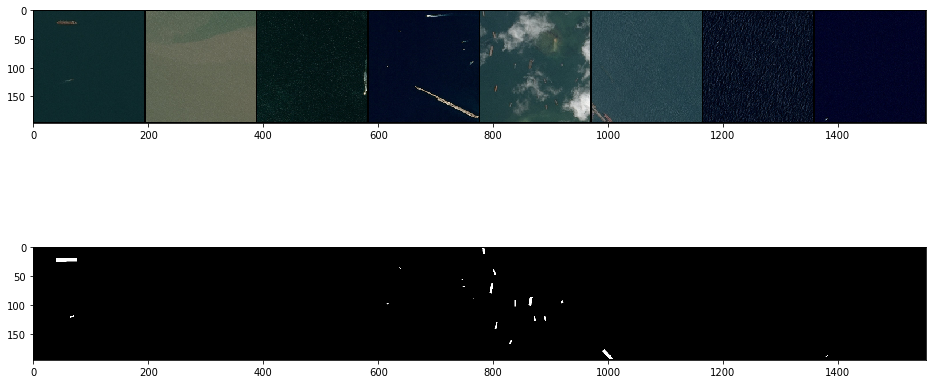

In [5]:
airimg = pp.AirbusDS(path, aug=True, resize_factor=4, mode='train')
# Use the torch dataloader to iterate through the dataset
loader = D.DataLoader(airimg, batch_size=8, shuffle=True, num_workers=0)

# get some images
dataiter = iter(loader)
images, masks, labels = dataiter.next()

# show images
plt.figure(figsize=(16,8))
plt.subplot(211)
pp.imshow(torchvision.utils.make_grid(images))
plt.subplot(212)
pp.imshow(torchvision.utils.make_grid(masks))
print(labels)

# Simple classification model

In [6]:
# ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*45*45, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = x.float()
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*45*45)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
net = net.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the model

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        # get the inputs
        inputs, masks, labels = data
        #labels = labels.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 64 == 63:    # print every ... mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 64))
            running_loss = 0.0

print('Finished Training')

[1,    64] loss: 0.561
[1,   128] loss: 0.527
[1,   192] loss: 0.558
[1,   256] loss: 0.460
[1,   320] loss: 0.521
[1,   384] loss: 0.521
[1,   448] loss: 0.509
[1,   512] loss: 0.509
[1,   576] loss: 0.520
[1,   640] loss: 0.521
[1,   704] loss: 0.525
[1,   768] loss: 0.479
[1,   832] loss: 0.517
[1,   896] loss: 0.533
[1,   960] loss: 0.500
[1,  1024] loss: 0.452
[1,  1088] loss: 0.486
[1,  1152] loss: 0.479
[1,  1216] loss: 0.493
[1,  1280] loss: 0.503
[1,  1344] loss: 0.447
[1,  1408] loss: 0.497
[1,  1472] loss: 0.470
[1,  1536] loss: 0.446
[1,  1600] loss: 0.437
[1,  1664] loss: 0.444
[1,  1728] loss: 0.470
[1,  1792] loss: 0.484
[1,  1856] loss: 0.516
[1,  1920] loss: 0.466
[1,  1984] loss: 0.531
[1,  2048] loss: 0.456
[1,  2112] loss: 0.525
[1,  2176] loss: 0.511
[1,  2240] loss: 0.472
[1,  2304] loss: 0.435
[1,  2368] loss: 0.477
[1,  2432] loss: 0.489
[1,  2496] loss: 0.507
[1,  2560] loss: 0.429
[1,  2624] loss: 0.492
[1,  2688] loss: 0.449
[1,  2752] loss: 0.414
[1,  2816] 

In [42]:
# Save the model
torch.save(net, '../cnn')

# Evaluation

GroundTruth:  tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1])


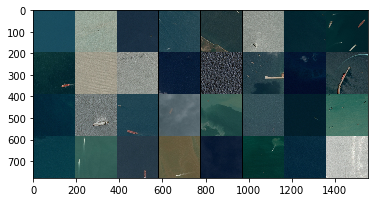

In [39]:
airimg = pp.AirbusDS(path, resize_factor=4, mode='test')
# Use the torch dataloader to iterate through the dataset
loader = D.DataLoader(airimg, batch_size=32, shuffle=True, num_workers=0)

dataiter = iter(loader)
images, labels = dataiter.next()

# print images
pp.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', labels)

In [40]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [43]:
# And now on the whole validation dataset

num_val_images = len(airimg.filenames)
correct = 0
total = 0
with torch.no_grad():
    for data in loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (num_val_images, 100 * correct / total))

Accuracy of the network on the 3655 test images: 80 %
